## xgboost results

This notebook contains the results from xgboost.

- XGBoost was first optmized with a very small grid (trees and learning rate)
- afterwards the selected features were used within a larger grid search space

We want to have the following results:
1. Results of the cross-validation
2. Results of the train / test split
3. SHAP results
4. interactions
5. target / decoys

Methods:
TBD

In [24]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import glob
shap.initjs()
#data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_small.p", "rb"))
#data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_AVG_huge.p", "rb"))
#data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_huge.p", "rb"))
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_OH_NAVG_huge.p", "rb"))

#data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_OH_AVG_tiny.p", "rb"))

data_dic.keys()
#dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

In [25]:
# takes very long?!
# get the summary metric data from all pickle files
#files = glob.glob(r"..\results\*.p")
#data_overview = []
#for i in files:
#    df_tmp = i.load(open(r"..\results\xifaims_8PM4PM_OH_AVG_tiny.p", "rb"))["metrics"]
#    df_tmp["file"] = i
#    data_overview.append(df_tmp)
#df_data_overview = pd.concat(data_overview)
#df_data_overview

## Train-Test Split

The following table summarizes the metrics for training on 80% of the data and then predicting on the other 20%.


In [26]:
metrics_df = data_dic["metrics"]
metrics_df = metrics_df.round(2)
metrics_df = metrics_df.set_index("split")
metrics_df

,r2,pearsonr,MAE,MSE
split,,,,
Train,0.88,0.95,3.02,15.18
Validation,0.52,0.72,5.80,60.05
DX,0.32,0.65,6.21,57.41


## Best features:

Using mlxtend and the nested SequentialFeatureSelector + GridSearch the following features get choosen through a parsimony criterium:

In [27]:
features = data_dic["best_features_gs"]
print(features)

print(data_dic["best_params_gs"])

Index(['length2', 'length1+length2', 'charge_3', 'charge_5', 'charge_8',
       'helix', 'pi', 'hydrophobic_ratio', 'intrinsic_size_sum',
       'intrinsic_size_max', 'mv_sum', 'mv_size_max', 'secondstruc_size_max',
       'm/z'],
      dtype='object')
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 0.1, 'n_estimators': 50, 'nthread': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'seed': 42, 'subsample': 0.8}


# Cross-validation results

The CV was done using 3splits and negative_mean_squared_error as metric.

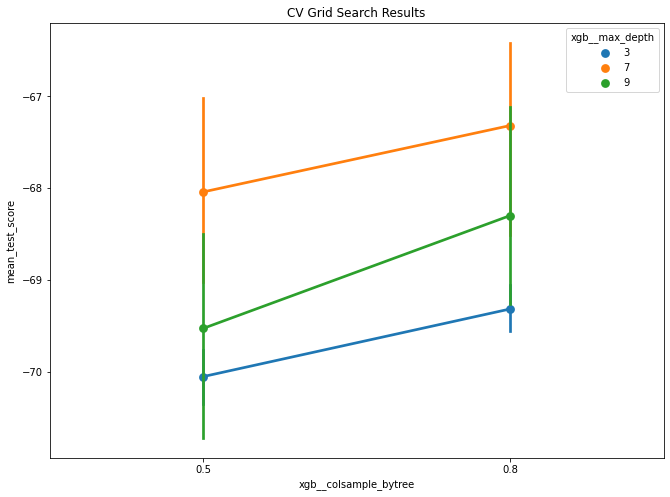

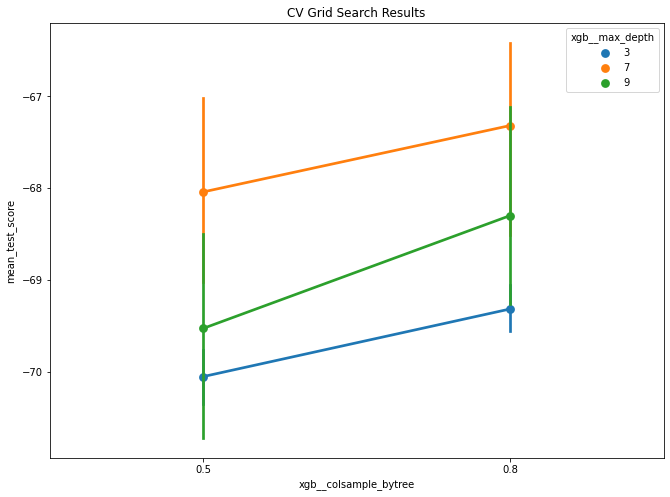

In [28]:
df_cv = data_dic["summary_gs"]
df_cv = df_cv.sort_values("rank_test_score", ascending=True)
df_cv.filter(regex="param|rank", axis=1).head(20)

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    #cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig


plot_cv_results(df_cv, "xgb__colsample_bytree", "xgb__max_depth")

In [29]:
best_cv = df_cv
best_cv
#print(best_cv)
best_df = df_cv.filter(regex="split|rank")
best_df


,split0_test_score,split1_test_score,split2_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score
983,-58.522015,-66.948910,-56.030152,1,-10.119107,-11.453295,-10.617348
967,-58.522015,-66.948910,-56.030152,1,-10.119107,-11.453295,-10.617348
637,-60.317980,-66.293178,-55.451307,3,-10.263464,-10.849705,-10.999394
653,-60.317980,-66.293178,-55.451307,3,-10.263464,-10.849705,-10.999394
941,-60.291222,-66.135536,-55.831102,5,-10.784078,-10.832574,-10.587301
...,...,...,...,...,...,...,...
556,-83.086461,-92.140331,-79.826619,1147,-2.129475,-1.066600,-1.991050
542,-81.229109,-93.211280,-83.173521,1149,-2.291130,-1.427275,-1.814809
558,-81.229109,-93.211280,-83.173521,1149,-2.291130,-1.427275,-1.814809
248,-85.617173,-93.911290,-85.833694,1151,-1.913041,-1.269381,-2.009159


In [30]:
res_melt = best_df.melt(id_vars=["rank_test_score"])
res_melt = res_melt[res_melt["rank_test_score"] == 1]
res_melt["Split"] = ["Train" if "train" in i else "Test" for i in res_melt["variable"]]
res_melt



,rank_test_score,variable,value,Split
0,1,split0_test_score,-58.522015,Test
1,1,split0_test_score,-58.522015,Test
1152,1,split1_test_score,-66.948910,Test
1153,1,split1_test_score,-66.948910,Test
2304,1,split2_test_score,-56.030152,Test
2305,1,split2_test_score,-56.030152,Test
3456,1,split0_train_score,-10.119107,Train
3457,1,split0_train_score,-10.119107,Train
4608,1,split1_train_score,-11.453295,Train
4609,1,split1_train_score,-11.453295,Train


## Train - Validation Evaluation

Evaluate the results when the model was trained on 80%.

In [31]:
predictions_df = data_dic["predictions_df"]
predictions_df.Split.unique()
predictions_df["Split"] = predictions_df["Split"].str.replace("Test", "Validation")
predictions_df
predictions_df["diff"] = predictions_df["predictions"] -  predictions_df["observed"]
predictions_df["diff_abs"] = np.abs(predictions_df["predictions"] -  predictions_df["observed"])
predictions_df["Split"] = [f"{i} ({metrics_df.loc[i]['pearsonr']})" for i in predictions_df["Split"]]
predictions_df.head()



,predictions,observed,Split,diff,diff_abs
0,-41.767471,-39.788752,Train (0.95),-1.978720,1.978720
1,-37.665749,-30.377792,Train (0.95),-7.287956,7.287956
2,-39.288204,-39.815768,Train (0.95),0.527563,0.527563
3,-54.521366,-49.570814,Train (0.95),-4.950552,4.950552
4,-37.596989,-40.478859,Train (0.95),2.881871,2.881871


<AxesSubplot:xlabel='Split', ylabel='diff'>

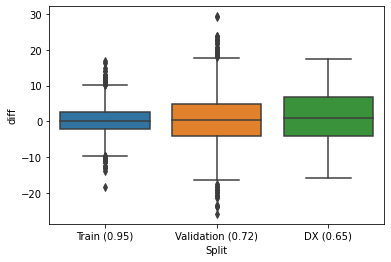

In [32]:
sns.boxplot(x="Split", y="diff", data=predictions_df)

<AxesSubplot:xlabel='Split', ylabel='diff_abs'>

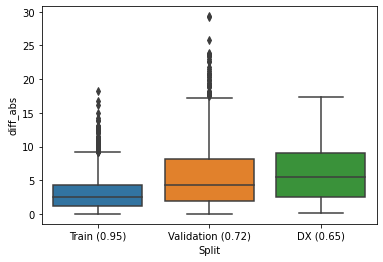

In [33]:
sns.boxplot(x="Split", y="diff_abs", data=predictions_df)

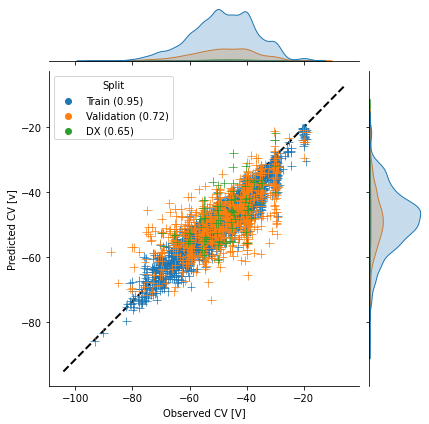

In [34]:
#fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df[predictions_df["Split"] != "DX"], marker="+", s=50)
fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80)
fax.ax_joint.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
x0, x1 = fax.ax_joint.get_xlim()
y0, y1 = fax.ax_joint.get_ylim()
fax.ax_joint.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")



### SHAP Analysis
Use shap to determine:
1. most important parameters
2. interesting interactions

In [35]:
print("Loading model, train, val, dx features and best features")
# model
model = data_dic["xgb"]
print(data_dic["data"].keys())

# data consists of tuples with meta data and feature data
all_data = data_dic["data"]
TT_train, TT_train_features = all_data["TT_train"] 
TT_val, TT_val_features = all_data["TT_val"] 
DX = all_data["DX"] 
#print(all_data)

# use shortcut
X = TT_val_features[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values_inter = shap.TreeExplainer(model).shap_interaction_values(X)

Loading model, train, val, dx features and best features
dict_keys(['TT_train', 'TT_val', 'DX'])


<AxesSubplot:xlabel='SHAP value (impact on model output)'>

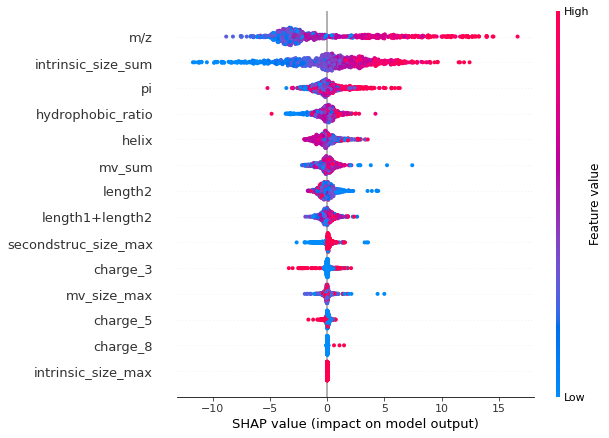

In [36]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
ax = plt.gca()
ax

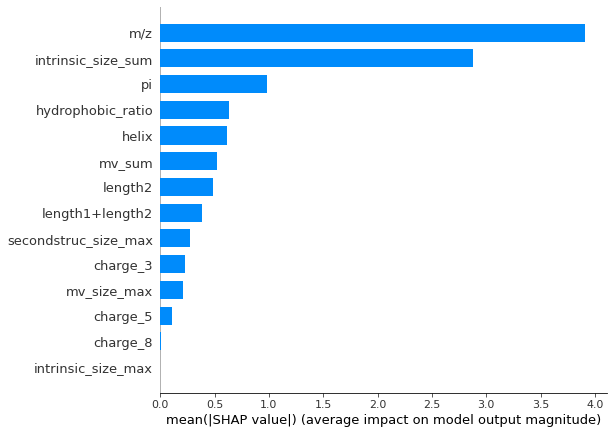

In [37]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [38]:
# shap viz
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [39]:
shap.force_plot(explainer.expected_value, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


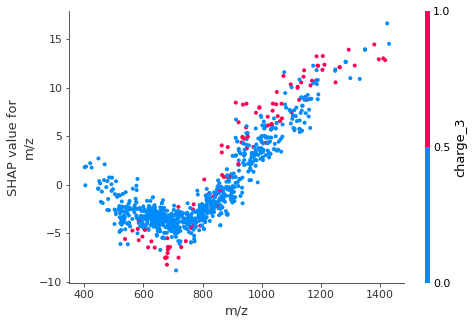

In [40]:
shap.dependence_plot("m/z", shap_values, X)

## Final Figure


In [41]:
res_melt

,rank_test_score,variable,value,Split
0,1,split0_test_score,-58.522015,Test
1,1,split0_test_score,-58.522015,Test
1152,1,split1_test_score,-66.948910,Test
1153,1,split1_test_score,-66.948910,Test
2304,1,split2_test_score,-56.030152,Test
2305,1,split2_test_score,-56.030152,Test
3456,1,split0_train_score,-10.119107,Train
3457,1,split0_train_score,-10.119107,Train
4608,1,split1_train_score,-11.453295,Train
4609,1,split1_train_score,-11.453295,Train


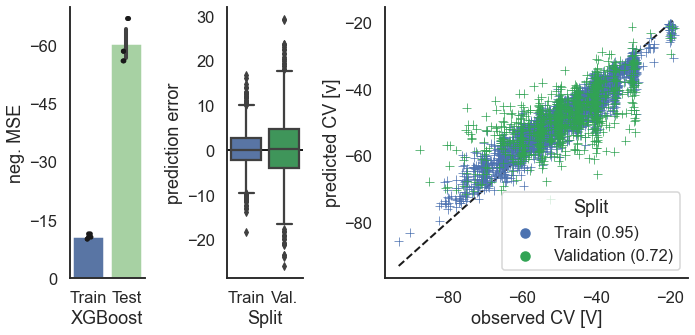

In [87]:
from matplotlib import ticker
predictions_df_TV = predictions_df[~predictions_df["Split"].str.contains("DX")]
order_cor = predictions_df_TV["Split"].unique()

train_col = "C0"
test_col =  "#a1d99b"
val_col = "#31a354"

sns.set(style="white", context="talk")
gridspec_kw={'width_ratios':[0.25, 0.25,  1]}
f, (ax0, ax2, ax1) = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec_kw)

# bar plot
ax0 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"], palette={"Train": train_col, "Test": test_col})
ax0 = sns.stripplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"], color="k")
ax0.set_ylim(0, -70)
ax0.set(xlabel="XGBoost", ylabel="neg. MSE")
ax0.yaxis.set_major_locator(ticker.MaxNLocator(5))
sns.despine(ax=ax0)


ax2 = sns.boxplot(x="Split", y="diff", data=predictions_df_TV, ax=ax2, palette={order_cor[0]: train_col, order_cor[1]: val_col})
ax2.axhline(0, lw=2, c="k", zorder=-1)
ax2.set(xticklabels=["Train", "Val."], ylabel="prediction error")
sns.despine(ax=ax2)

ax1 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df_TV, marker="+", s=80, ax=ax1, palette={order_cor[0]: train_col, order_cor[1]: val_col})
xmin = predictions_df_TV[["predictions", "observed"]].min().min()
xmax = predictions_df_TV[["predictions", "observed"]].max().max()
ax1.plot([xmin, xmax], [xmin, xmax], ls="--", zorder=-1, lw=2, c="k")
ax1.set(xlabel="observed CV [V]", ylabel="predicted CV [v]")
ax1.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
sns.despine(ax=ax1)

plt.tight_layout()

#ax2 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["train", "test"])
#ax3 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80, ax=ax3)


-93.1865087192603

In [ ]:
#%%
# retrieve the shap plot from above
shap.summary_plot(shap_values, X, show=False)
_ = plt.gcf()
_.ax
#ax4 = plt.gca()

shap.dependence_plot("m/z", shap_values, X, show=False)
ax3 = plt.gca()


In [88]:
TT_meta, TT_features = data_dic["data"]["TT_train"]
VAL_meta, VAL_features = data_dic["data"]["TT_val"]
VAL_meta = VAL_meta.reset_index()

z3 = VAL_meta[VAL_meta["exp charge"] == 3].index